<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Description" data-toc-modified-id="Description-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Description</a></span><ul class="toc-item"><li><span><a href="#Notes" data-toc-modified-id="Notes-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Notes</a></span></li></ul></li><li><span><a href="#Some-notes" data-toc-modified-id="Some-notes-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Some notes</a></span><ul class="toc-item"><li><span><a href="#Cost-functions" data-toc-modified-id="Cost-functions-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Cost functions</a></span></li></ul></li><li><span><a href="#Load" data-toc-modified-id="Load-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load</a></span><ul class="toc-item"><li><span><a href="#Viz-costs" data-toc-modified-id="Viz-costs-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Viz costs</a></span></li><li><span><a href="#Sampling-solutions" data-toc-modified-id="Sampling-solutions-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Sampling solutions</a></span></li></ul></li><li><span><a href="#Building-the-&quot;grid&quot;" data-toc-modified-id="Building-the-&quot;grid&quot;-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Building the "grid"</a></span></li></ul></div>

In [1]:
from matplotlib import rc
rc('text', usetex=True)
rc('font', size = 12)
rc('xtick', labelsize = 12)
rc('ytick', labelsize = 12)
rc('figure', figsize = (8, 4))

In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from amod_ed.contractivity_v3 import viz_costs, _construct_problem
from amod_ed.contractivity_v3 import sample_solutions, run_algorithm
import cvxpy as cp
import networkx as nx

import pandas as pd

from amod_ed.contractivity_v3 import plot_results_run, compute_error_KKT, get_d_values

from amod_ed.contractivity_v3 import get_new_r, get_edge_flow, get_flow_edge_od

# Description

This notebook implements a more general framework, to be essentially tested on a 3-node case. 

TODO: 
- Check for failures
- Test with different scenarios (i.e. parameters of the network)

## Notes

**We see there are still order 10-2 errors on the KKT with GUROBI**

**We also see the values are less accurate with ECOS -- hence the optimal inaccurate**

# Some notes

## Cost functions

In the different functions of the code, the cost functions and inverse demand functions are defined based on BPR functions (out of simplicity). 

We take the following notation: 

$$
BPR(x,\kappa, \phi) = \phi(1+\alpha (x/\kappa)^\beta),
$$
where $\alpha$ and $\beta$ are parameters. 

The edge costs are actually BPR functions. As for the inverse demand functions, we define them as
$$
D^{-1} = - BPR() + S,
$$
where $S\in\mathbb{R}^+$ is the inverse demand shift, ensuring that $D^{-1}$ is larger than zero over a given subset of $\mathbb{R}^+$.

# Load

The characteristics of the graph are loaded from Excel files. 

In [3]:
edges = pd.read_excel('cost_edges_3.xlsx')
inv_edges = pd.read_excel('inv_demand_3.xlsx')

In [4]:
edges['phi']=3

In [5]:
edges['k']=1

In [6]:
edges

,origin,destination,phi,k
0,1,2,3,1
1,2,1,3,1
2,1,3,3,1
3,3,1,3,1
4,2,3,3,1
5,3,2,3,1


In [7]:
inv_edges['k'] = .5

In [8]:
inv_edges['shift'] = 15

In [9]:
inv_edges['phi']+=1

In [10]:
inv_edges

,origin,destination,phi,k,shift
0,1,2,2,0.5,15
1,2,1,4,0.5,15
2,3,1,3,0.5,15
3,1,3,5,0.5,15
4,2,3,2,0.5,15
5,3,2,4,0.5,15


## Viz costs

Visualize the costs for each OD pair specified in the Excels. 

In [41]:
# inv_edges['shift'] = inv_edges['shift']+15

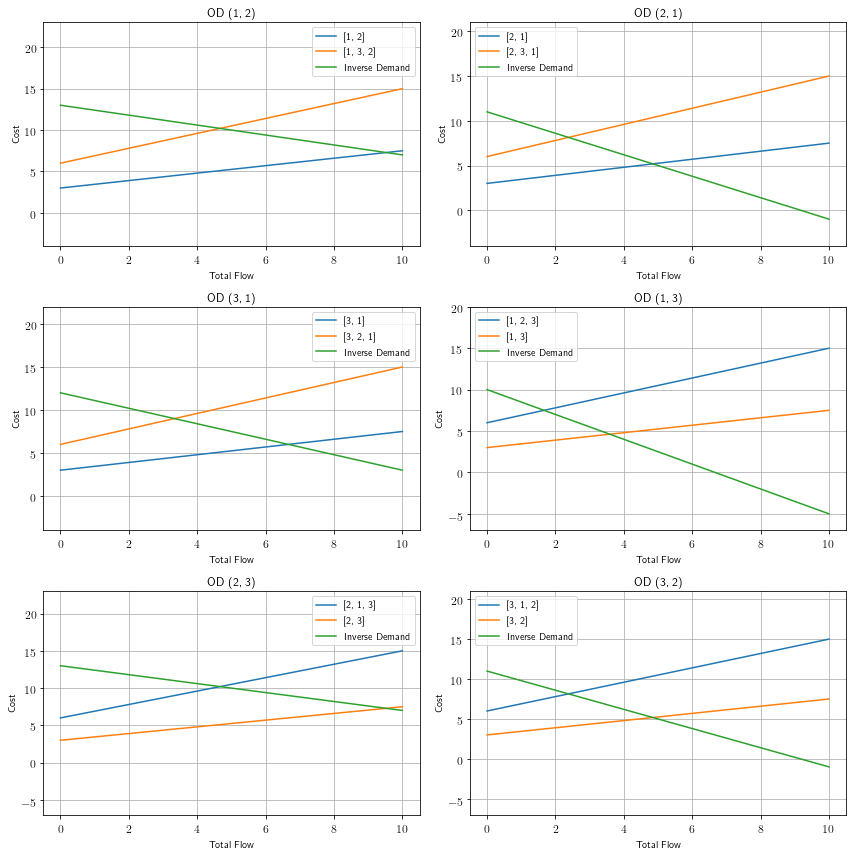

In [11]:
viz_costs(edges, inv_edges, name = 'costs1', save = False, correct = False, beta = 1)

## Sampling solutions

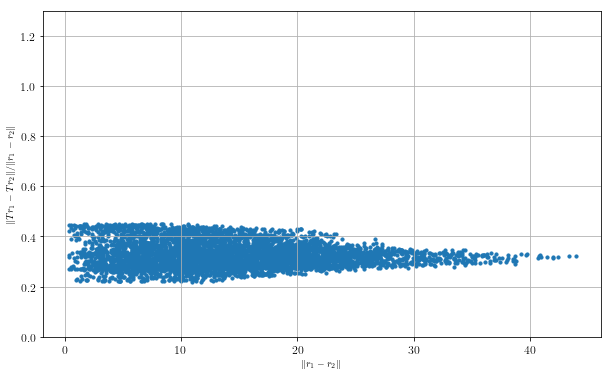

In [64]:
Tr, r_, dT, dr = sample_solutions(edges, inv_edges, solver = 'GUROBI', nsamples = 5000, seed=5, correct = False, beta = 1)

# Building the "grid"

In [14]:
correct = False

In [22]:
f_p, f_r, r, d_var, prob, map_comps, map_edges,\
 costs_dict, inv_d_dict, G, nodes = _construct_problem(edges, inv_edges, correct = correct, beta = 1)

In [50]:
N = 10

In [51]:
r_vec = np.linspace(-10, 10, N)

In [52]:
_map = []
_r = []
f = []

for r1 in r_vec:
    for r2 in r_vec:
        r3 = -(r1+r2)
        new_r = [r1, r2, r3]
        _r.append(new_r)
        r.value = new_r
        prob.solve(solver = cp.GUROBI)
        f.append(get_edge_flow(f_p, map_edges))
        _map.append(get_new_r(f_p, map_edges, nodes))

In [56]:
ratio_grid = np.zeros((len(_map), len(_map)))

for i in range(len(_r)):
    for j in range(len(_r)):
        r1 = np.array(_r[i])
        r2 = np.array(_r[j])
        Tr1 = np.array(_map[i])
        Tr2 = np.array(_map[j])
        ratio = np.linalg.norm(Tr1-Tr2)/np.linalg.norm(r1-r2)
        ratio_grid[i,j] = ratio
        
f_grid = np.zeros((len(r_vec), len(r_vec)))
f_grid2 = np.zeros((len(r_vec), len(r_vec)))
for i in range(len(r_vec)):
    for j in range(i, len(r_vec)):
#         print(i,j)
        idx = i*len(r_vec) + j
        f_grid[i,j] = f[idx][(1,2)]
        f_grid2[i,j] = f[idx][(3,1)]
        

/Users/lucasfuentes/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


In [45]:
import seaborn as sns

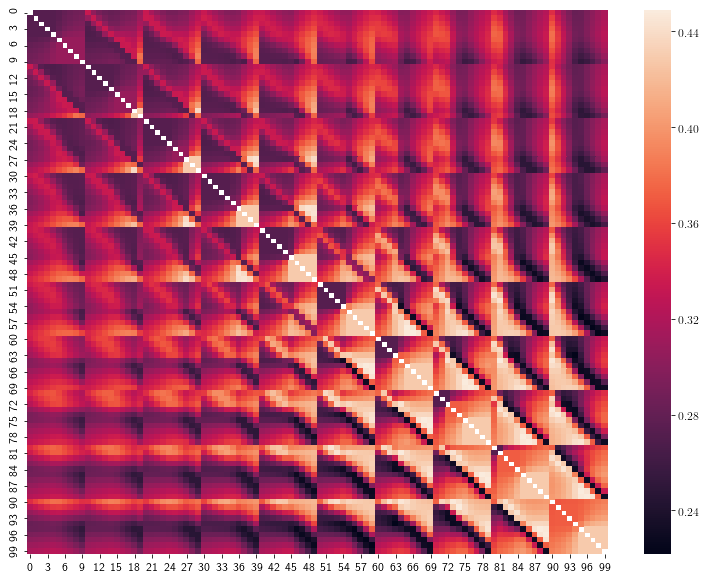

In [54]:
plt.figure(figsize = (13, 10))
sns.heatmap(ratio_grid)

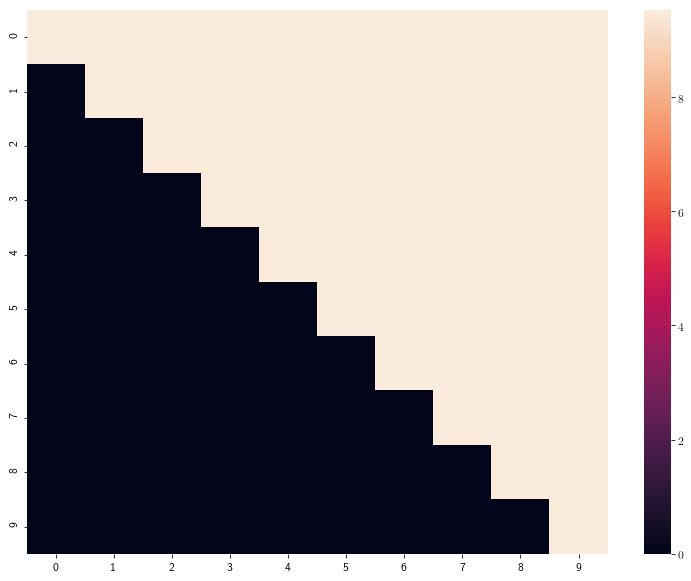

In [55]:
plt.figure(figsize = (13, 10))
sns.heatmap(f_grid)

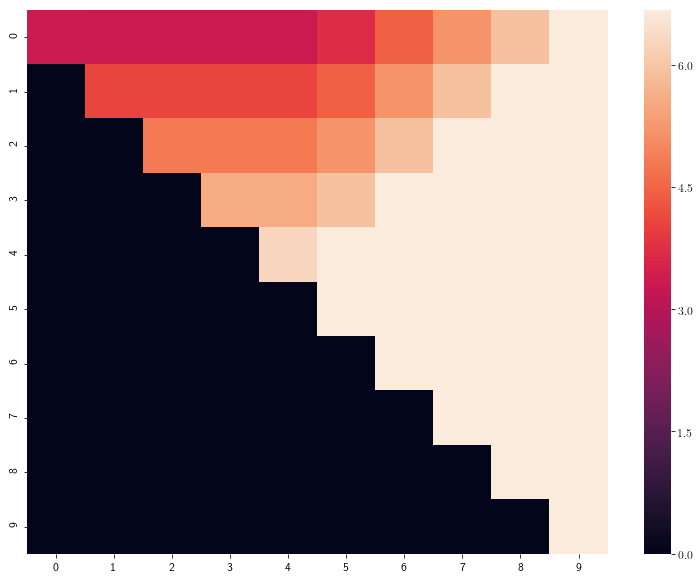

In [57]:
plt.figure(figsize = (13, 10))
sns.heatmap(f_grid2)

In [60]:
X, Y = np.meshgrid(r_vec, r_vec)

In [64]:
from mpl_toolkits import mplot3d

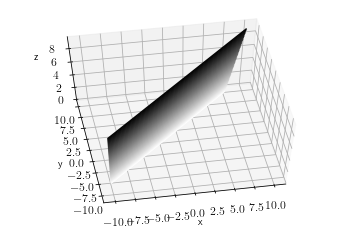

In [83]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.contour3D(X, Y, f_grid, 50, cmap='binary')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');
ax.view_init(60, -100)
